# <span style="color:red">**Download and pre-proccess list of neighborhoods in Toronto**</span>

### Importing relevant python libraries

In [1]:
#pip install lxml

In [2]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize 

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.cluster import MeanShift

!conda install -c conda-forge folium=0.5.0 --yes
import folium

from sklearn.cluster import DBSCAN

from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix
from sklearn.cluster import AgglomerativeClustering
import pylab

#from project_lib import Project

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Libraries imported.


### Download a table from wikipedia (containing Toronto neighborhoods) to a panda data frame & clean the data

In [3]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

df = pd.read_html(url, header=0)[0]

### Remove rows in which borough is unavailable

In [4]:
df = df[~df.Borough.str.contains("Not assigned")]

### Let's look at the data structure and see how many neighborhoods are included in each post code:

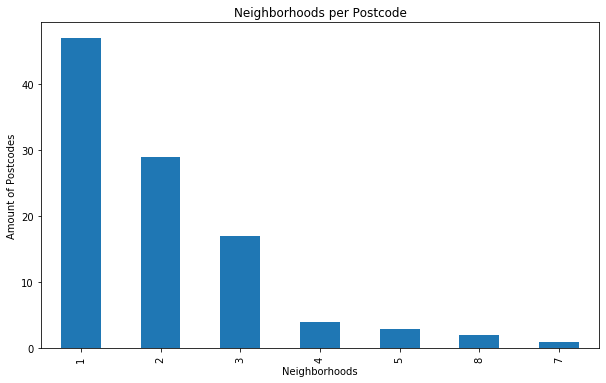

In [5]:
postcode_strct = df.groupby('Postcode').count()
postcode_strct = postcode_strct['Neighbourhood'].value_counts()
postcode_strct.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Neighborhoods')
plt.ylabel('Amount of Postcodes')
plt.title('Neighborhoods per Postcode')
mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10) 
plt.show()

### Considering the distribution shown in bar chart above, vast majority of post codes include 1-3 neighborhoods.
### It is reasonable therefore to treat postcodes as the data points to avoid breaking up the information to too 
### many meaningless pieces. Boroughs are too few (11) to consider them as an option.

In [6]:
df = df.groupby(['Postcode','Borough'])['Neighbourhood'].apply(', '.join).reset_index() # concatenate the neighborhoods using ","
df = df[['Postcode','Borough','Neighbourhood']]

### Replace unavailable neighborhoods with the corresponding borough title

In [7]:
df['Neighbourhood'].replace('Not assigned', df['Borough'], regex=True, inplace=True)
print("After cleaning and aggregating the data we are left with %d samples (postcodes)." % (df.shape[0]))
df.head()

After cleaning and aggregating the data we are left with 103 samples (postcodes).


,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### 103 samples is a good enough resolution for a clustering problem in a city.
### There are too many neighborhoods and too little boroughs to use as an alternative.

# <span style="color:red">**Add complementary geographical information**</span>

### Read coordinates from a CSV file prepared using Geocoder Python package

In [8]:
csv_url =   "https://cocl.us/Geospatial_data"
df_geocsv = pd.read_csv(csv_url)

### Example using GeoLocator on the city center

In [9]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Toronto are 43.653963, -79.387207.


### Rename column in GEO dataframe to enable merging with the neighborhood dataset

In [10]:
df_geocsv = df_geocsv.rename(columns={"Postal Code": "Postcode"})
df_geocsv.head(5)

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merge the two data frames, matching each post code with its GPS coordinates

In [11]:
df = df.merge(df_geocsv, on='Postcode')
df.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# <span style="color:red">**Analysis and Clustering**</span>

### Begin with showing on a map all Toronto's post codes:

In [12]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, Postcode in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Postcode']):
    label = '{}, {}'.format(Postcode, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [13]:
# @hidden_cell
CLIENT_ID = 'OKS30IYUTEGBIQU2QKLFEW0TS1Y12UFYCJAZZDBQHH1KCSOJ'
CLIENT_SECRET = 'CCWUL25WMG4VBK5XCZIIG4LJSS5H5VQND0LSDVZ2CWIXNAWY'
VERSION = '20180605'

### Moving on to retrieving the location of the venues in the city:
### Define the function that executes API request URL and returns results from foursquare engine.
### I have chosen the radius to be 0.5 KM since this is a short walking distance for the average person (5-10 min)

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
    

### Run above function (limited to 150 venues per call) with Toronto post codes and store it in a data frame

In [16]:
LIMIT = 150
toronto_venues = getNearbyVenues(names= df['Postcode'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

### Explore the generated venues:

In [17]:
print("In total we have %d venues" % (toronto_venues.shape[0]))
toronto_venues.rename(columns={"Venue Category": "Venue_Category"}, inplace = True)
toronto_venues.head()

In total we have 2234 venues


,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category
0,M1B,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,M1B,43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,M1C,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,M1E,43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,M1E,43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


### Explore and count the venue categories:

In [18]:
toronto_venues_cat = toronto_venues['Venue_Category']
toronto_venues_cat = toronto_venues_cat.value_counts()
toronto_venues_cat = toronto_venues_cat.to_frame()
toronto_venues_cat = toronto_venues_cat.reset_index()
toronto_venues_cat.columns = toronto_venues_cat.columns = ['Category', 'Freq']
print("In total we have %d venue categories" % (toronto_venues_cat.shape[0]))
toronto_venues_cat.head(50)

In total we have 274 venue categories


,Category,Freq
0,Coffee Shop,187
1,Café,102
2,Restaurant,62
3,Bakery,54
4,Pizza Place,54
5,Park,53
6,Italian Restaurant,51
7,Bar,45
8,Hotel,44
9,Sandwich Place,41


### I immediately see that there are too many restaurant types that have little meaning from my perspective:

In [19]:
restaurant_cat_qty = toronto_venues_cat.loc[toronto_venues_cat.Category.str.contains('Restaurant',case=False), 'Category'].size
print("We have %d different types of restaurants:" %(restaurant_cat_qty))
toronto_venues_cat.loc[toronto_venues_cat.Category.str.contains('Restaurant',case=False), 'Category']

We have 52 different types of restaurants:


2                           Restaurant
6                   Italian Restaurant
10                 Japanese Restaurant
13                Fast Food Restaurant
14                    Sushi Restaurant
15                 American Restaurant
18                  Seafood Restaurant
20                     Thai Restaurant
25                  Chinese Restaurant
28       Vegetarian / Vegan Restaurant
30                    Asian Restaurant
35                    Greek Restaurant
41                  Mexican Restaurant
42                   Indian Restaurant
46               Vietnamese Restaurant
50                   French Restaurant
56           Middle Eastern Restaurant
67                    Ramen Restaurant
71             New American Restaurant
72             Comfort Food Restaurant
75                Caribbean Restaurant
84           Latin American Restaurant
86            Mediterranean Restaurant
131             Gluten-free Restaurant
136              Portuguese Restaurant
144                Dumpli

### Now a little bit of proportion is unveiled: there are about 100 post codes, 250 venue categories 
### (~50 of which are restaurant types) and more than 2,000 venues. My conclusion is to analyze venues 
### on category level and treat all restaurants as the same type, modifying their category name in the original table:

In [20]:
toronto_venues.loc[toronto_venues.Venue_Category.str.contains('Restaurant',case=False), 'Venue_Category'] = 'Restaurant'
toronto_venues.head(10)

,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category
0,M1B,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Restaurant
1,M1B,43.806686,-79.194353,Interprovincial Group,43.805630,-79.200378,Print Shop
2,M1C,43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,M1E,43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,M1E,43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
5,M1E,43.763573,-79.188711,Marina Spa,43.766000,-79.191000,Spa
6,M1E,43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Restaurant
7,M1E,43.763573,-79.188711,Enterprise Rent-A-Car,43.764076,-79.193406,Rental Car Location
8,M1E,43.763573,-79.188711,Woburn Medical Centre,43.766631,-79.192286,Medical Center
9,M1E,43.763573,-79.188711,Lawrence Ave E & Kingston Rd,43.767704,-79.189490,Intersection



### Group by count for all venues in a given post code:

In [21]:
toronto_venues.groupby('Postcode').count()

,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category
Postcode,,,,,,
M1B,2,2,2,2,2,2
M1C,1,1,1,1,1,1
M1E,8,8,8,8,8,8
M1G,4,4,4,4,4,4
M1H,8,8,8,8,8,8
M1J,2,2,2,2,2,2
M1K,4,4,4,4,4,4
M1L,9,9,9,9,9,9
M1M,2,2,2,2,2,2


### post codes have a large variance in amount of nearby venues. 
### This is encouraging - the variance is the heart of the business problem.

In [22]:
print('There are {} uniques categories after reducing dimesions by aggregating restaurant types.'.format(len(toronto_venues['Venue_Category'].unique())))

There are 223 uniques categories after reducing dimesions by aggregating restaurant types.


### Now I can start encoding the above table to turn it into a vector that will serve as input to clustering algorithms.

### One hot encoding:

In [23]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue_Category']], prefix="", prefix_sep="")
toronto_onehot['Postcode'] = toronto_venues['Postcode'] 
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Postcode,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Candy Store,Check Cashing Service,Cheese Shop,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Electronics Store,Event Space,Farmers Market,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hospital,Hostel,Hotel,Hotel Bar,Housing Development,Ice Cream Shop,Indie Movie Theater,Intersection,Irish Pub,Jazz Club,Jewelry Store,Juice Bar,Lake,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Medical Center,Men's Store,Metro Station,Miscellaneous Shop,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Poutine Place,Print Shop,Pub,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Swim School,Taco Place,Tailor Shop,Tanning Salon,Tea Room,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Video Game Store,Video Store,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M1B,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,M1B,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,M1C,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Group the encoding by post code, aggregating by mean, such that every row will show the proportion of venues close to it:

In [24]:
toronto_grouped = toronto_onehot.groupby('Postcode').mean().reset_index()
toronto_grouped.head()

,Postcode,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Antique Shop,Aquarium,Art Gallery,Arts & Crafts Store,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Candy Store,Check Cashing Service,Cheese Shop,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Gym,College Rec Center,College Stadium,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dog Run,Donut Shop,Drugstore,Electronics Store,Event Space,Farmers Market,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,Fraternity House,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Golf Course,Gourmet Shop,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hospital,Hostel,Hotel,Hotel Bar,Housing Development,Ice Cream Shop,Indie Movie Theater,Intersection,Irish Pub,Jazz Club,Jewelry Store,Juice Bar,Lake,Lawyer,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Medical Center,Men's Store,Metro Station,Miscellaneous Shop,Monument / Landmark,Motel,Movie Theater,Museum,Music Venue,Neighborhood,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Poutine Place,Print Shop,Pub,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Swim School,Taco Place,Tailor Shop,Tanning Salon,Tea Room,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Video Game Store,Video Store,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.000,0.500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### Now the vector is almost ready. Dimensions need to be reduced to about 10 major venue categories that will become "essential services".
### This will not only turn the formulated problem to a much more focused one but also allow the different algorithms to deliver better results.
### Since there are about 100 post codes, it's wise to drop categories that are relatively rare since the city probably does not require them in 
### great numbers. In order to do that a threshold is needed. Setting it proportionally, to 15% of of post codes quantity sounds like a good idea. 
### This means there are at least 15 instances of a given venue category in the city.
### My assumption here is that a service that is available today in less than 15% of post codes is not important enough.

In [25]:
toronto_venues_cat_top = toronto_venues_cat[toronto_venues_cat.Freq > 15].copy()
toronto_venues_cat_top.loc[toronto_venues_cat_top.Category.str.contains('Restaurant',case=False), 'Category'] = 'Restaurant'
toronto_venues_cat_top = toronto_venues_cat_top.groupby(['Category']).sum()
toronto_venues_cat_top.sort_values(by=['Freq'], ascending=False, inplace=True)
toronto_venues_cat_top

,Freq
Category,
Restaurant,360
Coffee Shop,187
Café,102
Bakery,54
Pizza Place,54
Park,53
Bar,45
Hotel,44
Sandwich Place,41


### From here I will manually pick the top 10 services to define as essential while further reducing dimensions. I chose:
### Restaurant, Coffee shop \ Cafe, Park, Bakery \ Pizza, Hotel, Gym \ Gym-fitness center, Grocery Store, Pub, Pharmacy, Bank.

In [26]:
Vector = toronto_grouped[['Restaurant', 'Coffee Shop', 'Café', 'Park', 'Bakery', 'Pizza Place', 'Hotel', 'Gym', 'Gym / Fitness Center', 'Grocery Store', 'Pub', 'Pharmacy', 'Bank']]
Vector.head()

,Restaurant,Coffee Shop,Café,Park,Bakery,Pizza Place,Hotel,Gym,Gym / Fitness Center,Grocery Store,Pub,Pharmacy,Bank
0,0.500,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000
1,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000
2,0.125,0.0,0.0,0.0,0.000,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.000
3,0.500,0.5,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000
4,0.375,0.0,0.0,0.0,0.125,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.125


In [27]:
Vector['Coffee'] = Vector[['Coffee Shop', 'Café']].sum(axis=1)
Vector['Pastries'] = Vector[['Bakery', 'Pizza Place']].sum(axis=1)
Vector['Workout'] = Vector[['Gym', 'Gym / Fitness Center']].sum(axis=1)
Vector.drop(columns=['Coffee Shop', 'Café', 'Bakery', 'Pizza Place', 'Gym', 'Gym / Fitness Center'], inplace = True)
Vector.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout
0,0.500,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0
1,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0
2,0.125,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.125,0.0
3,0.500,0.0,0.0,0.0,0.0,0.0,0.000,0.5,0.000,0.0
4,0.375,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.125,0.0


### Now that I have a vector with 10 dimensions, I need to normalize the remaining proportions:

In [28]:
Vector["sum"] = Vector.sum(axis=1)
Vector_norm = Vector.loc[:,"Restaurant":"Workout"].div(Vector["sum"], axis=0)
Vector_norm.fillna(0, inplace = True)
Vector_norm.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
3,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
4,0.6,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.0


### I begin with with one of the most popular clustering algorithms - K means.
### Initial assumption is that 10 is a reasonable amount of target clusters.

In [29]:
kclusters = 10
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Vector_norm)
cluster_results = kmeans.labels_

### Displaying amount of samples clustered to each bin will allow me to see if 10 was a decent choice:

In [30]:
np.bincount(cluster_results)

array([ 4, 13,  9, 26,  9,  1, 10,  3,  7, 19])

### Distribution seems sane so let's integrate the results with the post codes and the normalized vector:

In [31]:
Summary = Vector_norm.copy()
Summary.insert(0, 'K Cluster Labels', kmeans.labels_)
Summary.insert(0, 'Postcode', toronto_grouped['Postcode'])
Summary.head()

,Postcode,K Cluster Labels,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout
0,M1B,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M1C,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M1E,1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
3,M1G,3,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0
4,M1H,1,0.6,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.0


### Now I'll try to determine the optimal K more precisely using the Silhouette score metric:

In [32]:
range_n_clusters = list (range(3,30))
print ("Number of clusters from 2 to 9: \n", range_n_clusters)
for n_clusters in range_n_clusters:
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(Vector_norm)
    centers = clusterer.cluster_centers_

    score = silhouette_score (Vector_norm, preds, metric='euclidean')
    print ("For %d clusters, average Silhouette score is %.2f" % (n_clusters, score))

Number of clusters from 2 to 9: 
 [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
For 3 clusters, average Silhouette score is 0.35
For 4 clusters, average Silhouette score is 0.38
For 5 clusters, average Silhouette score is 0.28
For 6 clusters, average Silhouette score is 0.42
For 7 clusters, average Silhouette score is 0.40
For 8 clusters, average Silhouette score is 0.42
For 9 clusters, average Silhouette score is 0.42
For 10 clusters, average Silhouette score is 0.44
For 11 clusters, average Silhouette score is 0.37
For 12 clusters, average Silhouette score is 0.40
For 13 clusters, average Silhouette score is 0.40
For 14 clusters, average Silhouette score is 0.41
For 15 clusters, average Silhouette score is 0.42
For 16 clusters, average Silhouette score is 0.41
For 17 clusters, average Silhouette score is 0.42
For 18 clusters, average Silhouette score is 0.42
For 19 clusters, average Silhouette score is 0.42
For 20 clusters, aver

### It can be seen that the optimal amount of K is around the scale of 10 clusters. No exact answer here.
### Running this several times demonstrates that it is reasonable to keep K = 10 when clustering with K means.
### The GPS coordinates need to be merged here in order to display the clusters on the map:

In [33]:
Summary = Summary.join(df_geocsv.set_index('Postcode'), on='Postcode')
Summary.head()

,Postcode,K Cluster Labels,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout,Latitude,Longitude
0,M1B,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.806686,-79.194353
1,M1C,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.784535,-79.160497
2,M1E,1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,43.763573,-79.188711
3,M1G,3,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,43.770992,-79.216917
4,M1H,1,0.6,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.0,43.773136,-79.239476


### Visualizing the clusters on the map might add additional insight in terms of geographical distribution.
### K means, being what it is, goes for the minimum distance in a euclidean n-dimensional space thus 
### expanding equally to all dimensions. This brings mostly to "soft clustering" with cluster members somewhat 
### similar to one another, having lots of services but no clear picture in terms of characteristics. The only
### true pattern that can be clearly seen are groups with post codes having only 1 or 0 services in them:

In [34]:
Kcluster_Chart = Summary.groupby(['K Cluster Labels'])['Restaurant','Park','Hotel','Grocery Store', 'Pub', 'Pharmacy', 'Bank', 'Coffee', 'Pastries', 'Workout'].mean()
Kcluster_Chart

,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout
K Cluster Labels,,,,,,,,,,
0,0.000000,0.050000,0.050000,0.600000,0.000000,0.000000,0.050000,0.000000,0.125000,0.125000
1,0.404701,0.050000,0.000000,0.038462,0.015385,0.047009,0.034615,0.037393,0.319658,0.052778
2,0.037037,0.962963,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.394472,0.042878,0.035571,0.027552,0.030253,0.010362,0.013526,0.321042,0.074536,0.049809
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.033333,0.275556,0.033333,0.011111,0.016667,0.153333,0.072222,0.112222,0.220000,0.072222
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
8,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### When looking at the map I am able to easily spot the dense Toronto areas which are close to 
### the shore line. It is even possible to try and split them into two: super-dense and mildly-dense. 
### They are located in clusters #3 & #9 (respectively):

In [35]:
map_clusters_Kmeans = folium.Map(location=[latitude, longitude], zoom_start=11)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(Summary['Latitude'], Summary['Longitude'], Summary['Postcode'], Summary['K Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_Kmeans)
       
map_clusters_Kmeans

### An example for a single service cluster can be found in cluster #8 with only restaurants in it:

In [36]:
Summary.loc[Summary['K Cluster Labels'] == 8]

,Postcode,K Cluster Labels,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout,Latitude,Longitude
0,M1B,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.806686,-79.194353
8,M1M,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.716316,-79.239476
10,M1P,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.757410,-79.273304
12,M1S,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.794200,-79.262029
16,M2H,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.803762,-79.363452
79,M6M,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.691116,-79.476013
92,M9B,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.650943,-79.554724


### It is also interesting to use an area chart to visualize the traits I was talking 
### about earlier - softness degree and similarity:

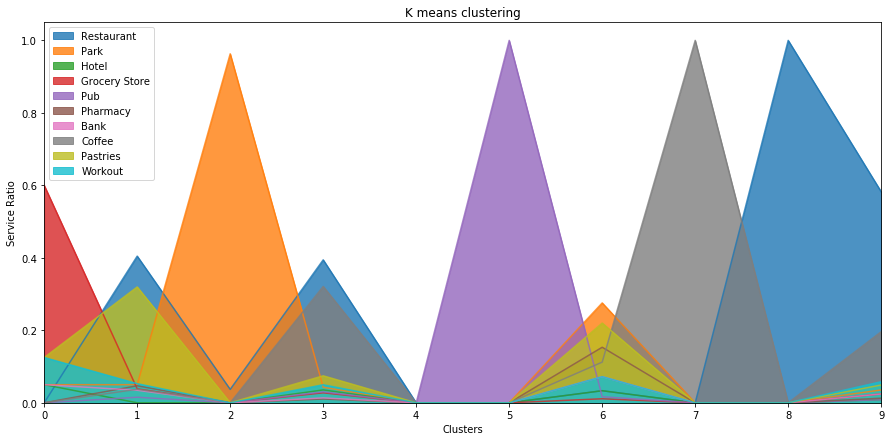

In [37]:
Kcluster_Chart.plot(kind='area', 
             stacked=False,
             figsize=(15, 7),
             alpha=0.8,
             )

plt.title('K means clustering')
plt.ylabel('Service Ratio')
plt.xlabel('Clusters')

plt.show()

### The single-color high spikes show clusters with one dominant service in total. These are less common.
### The lower ones, having multiple colors and medium height are the best expressions to soft results.
### The more lines a triangle has inside it the heavier its density and abundance of services.

In [38]:
###

### Now, I will try to use density based algorithms to see if I am missing some understanding
### due to the method with which K means groups data points. DBSCAN should put emphasis 
### on more significant similarity of dimensions advancing in space with limited steps
### based on epsilon parameter and without a target in terms of number of clusters.

In [39]:
epsilon = 0.3
minimumSamples = 3
db = DBSCAN(eps=epsilon, min_samples=minimumSamples, metric="l2").fit(Vector_norm)
db.labels_

array([ 0,  1,  2,  2,  2, -1,  3, -1,  0,  3,  0,  2,  0,  2,  4,  2,  0,
        2,  2,  1,  1,  2, -1, -1,  4,  2,  2,  2,  2,  4, -1,  1, -1,  2,
        2, -1, -1,  2,  2,  4,  2,  2,  2,  4, -1,  2,  2, -1,  2,  4,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1, -1,  2,  2,  2,  3,
        2,  2,  2,  2,  1, -1, -1,  2,  2,  2, -1,  0, -1,  2,  2,  2,  2,
        2,  2,  2,  2,  4,  1, -1,  0, -1,  2,  1,  4, -1, -1, -1,  1])

### Add results to the summary table:

In [40]:
#Summary.drop(columns=['DBSCAN Cluster Labels'], inplace = True)
Summary.insert(0, 'DBSCAN Cluster Labels', db.labels_)
Summary.head()

,DBSCAN Cluster Labels,Postcode,K Cluster Labels,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout,Latitude,Longitude
0,0,M1B,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.806686,-79.194353
1,1,M1C,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.784535,-79.160497
2,2,M1E,1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,43.763573,-79.188711
3,2,M1G,3,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,43.770992,-79.216917
4,2,M1H,1,0.6,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.0,43.773136,-79.239476


### As expected, there's more meaning to each cluster here and the hard clustering can be noticed.
### Unlike with K-means, DBSCAN grouped all the dense post codes to a single group (#2). The other 
### clusters include, as before, single\zero service post codes.

In [41]:
DBSCAN_Chart = Summary.groupby(['DBSCAN Cluster Labels'])['Restaurant','Park','Hotel','Grocery Store', 'Pub', 'Pharmacy', 'Bank', 'Coffee', 'Pastries', 'Workout'].mean()
DBSCAN_Chart

,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout
DBSCAN Cluster Labels,,,,,,,,,,
-1,0.125758,0.216591,0.026667,0.158636,0.050000,0.064167,0.035000,0.067348,0.176667,0.079167
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.457974,0.032017,0.020209,0.018857,0.024318,0.025447,0.027539,0.228462,0.114697,0.050479
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
4,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### For example, here's a list of post codes having only a coffee:

In [73]:
Summary.loc[Summary['DBSCAN Cluster Labels'] == 3]

,HR Cluster Labels,GMM Cluster Labels,MeanShift Cluster Labels,DBSCAN Cluster Labels,Postcode,K Cluster Labels,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout,Latitude,Longitude
6,7,4,3,3,M1K,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,43.727929,-79.262029
9,7,4,3,3,M1N,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,43.692657,-79.264848
67,7,4,3,3,M5V,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,43.628947,-79.394420


### Comparing between the charts one can see that DBSCAN is quite the dichotomy:
### either an "empty" spike (single service) or a filled one (dense):

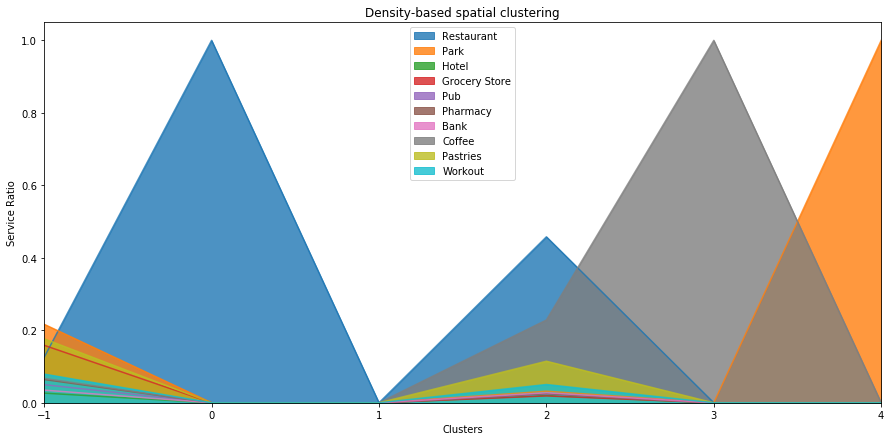

In [43]:
DBSCAN_Chart.plot(kind='area', 
             stacked=False,
             figsize=(15, 7),
             alpha=0.8,
             )

plt.title('Density-based spatial clustering')
plt.ylabel('Service Ratio')
plt.xlabel('Clusters')

plt.show()

### Putting this on a map, we indeed see the clustering has little geographical value to it.
### DBSCAN is too crude for that, looking for strong correlation between dimensions.

In [44]:
map_clusters_DBSCAN = folium.Map(location=[latitude, longitude], zoom_start=11)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(Summary['Latitude'], Summary['Longitude'], Summary['Postcode'], Summary['DBSCAN Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_DBSCAN)
       
map_clusters_DBSCAN

### DBSCAN did not deliver any additional value due to the fact it was too crude.
### so I will try another density based algorithm named MeanShift:

In [45]:
MS = MeanShift(bandwidth=0.5).fit(Vector_norm)
MS.labels_

array([0, 0, 0, 0, 0, 7, 3, 2, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       5, 0, 1, 0, 0, 0, 0, 1, 6, 0, 6, 0, 0, 4, 8, 0, 0, 1, 0, 0, 0, 1,
       6, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0])

In [46]:
#Summary.drop(columns=['MeanShift Cluster Labels'], inplace = True)
Summary.insert(0, 'MeanShift Cluster Labels', MS.labels_)
Summary.head()

,MeanShift Cluster Labels,DBSCAN Cluster Labels,Postcode,K Cluster Labels,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout,Latitude,Longitude
0,0,0,M1B,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.806686,-79.194353
1,0,1,M1C,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.784535,-79.160497
2,0,2,M1E,1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,43.763573,-79.188711
3,0,2,M1G,3,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,43.770992,-79.216917
4,0,2,M1H,1,0.6,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.0,43.773136,-79.239476


### After seeing the results, it is only natural they are similar to DBSCAN.
### However, DBSCAN has 2 parameters (distance+min members) while meanshift 
### has only one (distance), being less crude. This actually brings interesting
### results, showing clusters in the "middle of the spectrum" - not covered yet
### by neither DBSCAN nor K means:

In [47]:
MeanShift_Chart = Summary.groupby(['MeanShift Cluster Labels'])['Restaurant','Park','Hotel','Grocery Store', 'Pub', 'Pharmacy', 'Bank', 'Coffee', 'Pastries', 'Workout'].mean()
MeanShift_Chart

,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout
MeanShift Cluster Labels,,,,,,,,,,
0,0.431570,0.033471,0.013991,0.022962,0.016836,0.02766,0.019065,0.175435,0.099064,0.044563
1,0.037037,0.962963,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
2,0.062500,0.312500,0.000000,0.125000,0.000000,0.00000,0.000000,0.000000,0.500000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000
4,0.000000,0.500000,0.000000,0.000000,0.000000,0.50000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.500000,0.000000,0.000000,0.000000,0.00000,0.500000,0.000000,0.000000,0.000000
6,0.000000,0.177778,0.177778,0.300000,0.000000,0.00000,0.066667,0.000000,0.000000,0.277778
7,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000


### Take for example cluster #2, having a combination of few services per post code, but not too many!
### This is very interesting, allowing us to spot new patterns:

In [74]:
Summary.loc[Summary['MeanShift Cluster Labels'] == 2]

,HR Cluster Labels,GMM Cluster Labels,MeanShift Cluster Labels,DBSCAN Cluster Labels,Postcode,K Cluster Labels,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout,Latitude,Longitude
7,8,5,2,-1,M1L,1,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,43.711112,-79.284577
78,2,5,2,-1,M6L,6,0.00,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,43.713756,-79.490074
80,2,5,2,-1,M6N,0,0.00,0.00,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,43.673185,-79.487262
98,2,5,2,-1,M9R,6,0.00,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,43.688905,-79.554724


### 

### The area chart demonstrates this as well:

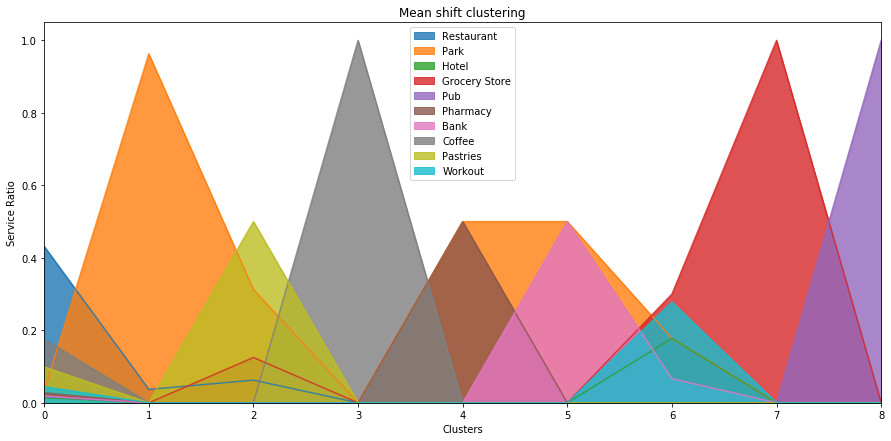

In [49]:
MeanShift_Chart.plot(kind='area', 
             stacked=False,
             figsize=(15, 7),
             alpha=0.8,
             )

plt.title('Mean shift clustering')
plt.ylabel('Service Ratio')
plt.xlabel('Clusters')

plt.show()

### After applying K means and density algorithms, I should explore a 3rd direction combining both 
### and delivering results in a similar fashion of the balanced MeanShift. On the one hand, we need 
### to run a "soft clustering" algorithm to be able to cluster data points with weaker correlation. 
### On the other, we need to be able to form clusters with more patterns in them. The chosen algorithm 
### is GMM (Gaussian Mixture Model) - providing flexibility in terms of shape and structure:

In [50]:
from sklearn.mixture import GaussianMixture
GMM = GaussianMixture(n_components=10)
GMM.fit(Vector_norm)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

### I used 10 clusters, similar to the choice in K-means (which also make fundamental logic 
### in ratio to total post codes amount):

In [51]:
GMM_labels = GMM.predict(Vector_norm)
GMM_labels

array([3, 0, 5, 9, 9, 8, 4, 5, 3, 4, 3, 9, 3, 9, 2, 9, 3, 9, 9, 0, 0, 1,
       6, 6, 2, 9, 9, 9, 9, 2, 6, 0, 8, 9, 9, 6, 7, 9, 6, 2, 9, 1, 1, 2,
       6, 1, 1, 9, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 0, 2, 1, 1,
       1, 4, 1, 1, 9, 6, 0, 2, 1, 6, 1, 9, 5, 3, 5, 1, 9, 1, 1, 1, 6, 9,
       6, 2, 0, 9, 3, 6, 5, 0, 2, 5, 5, 9, 0])

In [52]:
#Summary.drop(columns=['GMM Cluster Labels'], inplace = True)
Summary.insert(0, 'GMM Cluster Labels', GMM_labels)
Summary.head()

,GMM Cluster Labels,MeanShift Cluster Labels,DBSCAN Cluster Labels,Postcode,K Cluster Labels,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout,Latitude,Longitude
0,3,0,0,M1B,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.806686,-79.194353
1,0,0,1,M1C,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.784535,-79.160497
2,5,0,2,M1E,1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,43.763573,-79.188711
3,9,0,2,M1G,3,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,43.770992,-79.216917
4,9,0,2,M1H,1,0.6,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.0,43.773136,-79.239476


### Now let's see the cluster both on a map and on a chart:

In [53]:
GMM_Chart = Summary.groupby(['GMM Cluster Labels'])['Restaurant','Park','Hotel','Grocery Store', 'Pub', 'Pharmacy', 'Bank', 'Coffee', 'Pastries', 'Workout'].mean()

In [54]:
GMM_Chart

,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout
GMM Cluster Labels,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.444956,0.046018,0.038975,0.020076,0.030392,0.007495,0.005832,0.278529,0.083197,0.044530
2,0.083333,0.916667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5,0.214286,0.178571,0.000000,0.071429,0.000000,0.000000,0.000000,0.035714,0.500000,0.000000
6,0.103030,0.214141,0.048485,0.046465,0.033333,0.139394,0.083838,0.102020,0.145455,0.083838
7,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000


In [55]:
map_clusters_GMM = folium.Map(location=[latitude, longitude], zoom_start=11)
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
markers_colors = []
for lat, lon, poi, cluster in zip(Summary['Latitude'], Summary['Longitude'], Summary['Postcode'], Summary['GMM Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_GMM)
       
map_clusters_GMM

### It's good to see there is some geographical sense in the clustering, seen in the grouping of the 
### dense post codes near the shore. We can spot 2-4 groups of those dense clusters while the chart 
### also contains some high & medium spikes:

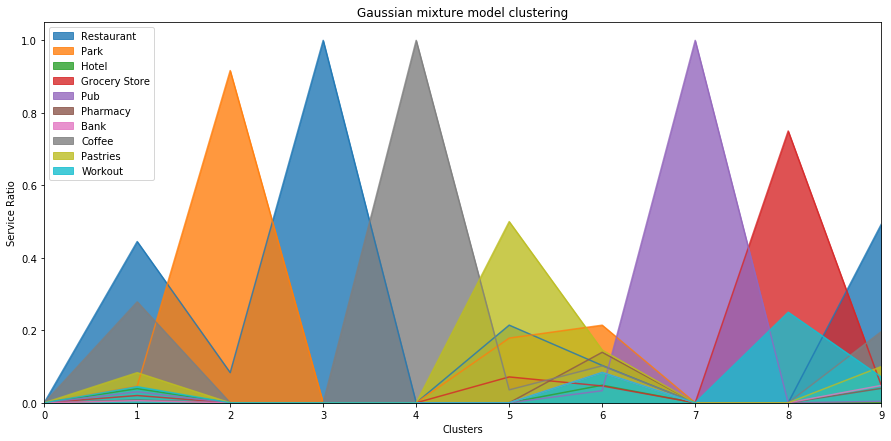

In [56]:
GMM_Chart.plot(kind='area', 
             stacked=False,
             figsize=(15, 7),
             alpha=0.8,
             )

plt.title('Gaussian mixture model clustering')
plt.ylabel('Service Ratio')
plt.xlabel('Clusters')

plt.show()

### All in all, I can see 3 major types of clusters in GMM's results:
### 1. Geographically dense with lots of different services in them (several types)
### 2. Clusters with post codes that have a single service in them at most (or nothing at all)
### 3. Clusters with post codes having a certain combination of services, usually 2-3

In [57]:
GMM_Chart

,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout
GMM Cluster Labels,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.444956,0.046018,0.038975,0.020076,0.030392,0.007495,0.005832,0.278529,0.083197,0.044530
2,0.083333,0.916667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
5,0.214286,0.178571,0.000000,0.071429,0.000000,0.000000,0.000000,0.035714,0.500000,0.000000
6,0.103030,0.214141,0.048485,0.046465,0.033333,0.139394,0.083838,0.102020,0.145455,0.083838
7,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000


### These results are the best generated so far. While K means was informative but too soft to generate
### any interesting groupings and the density based algorithms were too crude, GMM is very much in the gold
### middle. Type 3 clusters are very interesting because they shows us what service combinations work in 
### reality. Therefore, if only 2/3 are present in some post code the missing service has potential for 
### success there. For example, cluster #5. Post codes usually have a restaurant+pastries+coffee\grocery\park. 
### M6L\M6N lack a restaurant. Wouldn't it be a good idea to consider setting one up there?

In [77]:
Summary.loc[Summary['GMM Cluster Labels'] == 5]

,HR Cluster Labels,GMM Cluster Labels,MeanShift Cluster Labels,DBSCAN Cluster Labels,Postcode,K Cluster Labels,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout,Latitude,Longitude
2,8,5,0,2,M1E,1,0.50,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.5,0.0,43.763573,-79.188711
7,8,5,2,-1,M1L,1,0.25,0.25,0.0,0.0,0.0,0.0,0.0,0.00,0.5,0.0,43.711112,-79.284577
78,2,5,2,-1,M6L,6,0.00,0.50,0.0,0.0,0.0,0.0,0.0,0.00,0.5,0.0,43.713756,-79.490074
80,2,5,2,-1,M6N,0,0.00,0.00,0.0,0.5,0.0,0.0,0.0,0.00,0.5,0.0,43.673185,-79.487262
94,8,5,0,2,M9L,1,0.50,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.5,0.0,43.756303,-79.565963
97,8,5,0,-1,M9P,1,0.25,0.00,0.0,0.0,0.0,0.0,0.0,0.25,0.5,0.0,43.696319,-79.532242
98,2,5,2,-1,M9R,6,0.00,0.50,0.0,0.0,0.0,0.0,0.0,0.00,0.5,0.0,43.688905,-79.554724


### One final approach to test is the hierarchical clustering. It also considered as a "softer solution" and
### it is more efficient to use MAX(complete) in the metric parameter such that data points will not be 
### aggregated too aggressively. Also, 10 clusters will be the target as before:

In [59]:
agglom = AgglomerativeClustering(n_clusters = 10, linkage = 'complete')
HR_labels = agglom.fit_predict(Vector_norm)

In [60]:
#Summary.drop(columns=['HR Cluster Labels'], inplace = True)
Summary.insert(0, 'HR Cluster Labels', HR_labels)
Summary.head()

,HR Cluster Labels,GMM Cluster Labels,MeanShift Cluster Labels,DBSCAN Cluster Labels,Postcode,K Cluster Labels,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout,Latitude,Longitude
0,0,3,0,0,M1B,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.806686,-79.194353
1,4,0,0,1,M1C,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.784535,-79.160497
2,8,5,0,2,M1E,1,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,43.763573,-79.188711
3,6,9,0,2,M1G,3,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,43.770992,-79.216917
4,8,9,0,2,M1H,1,0.6,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.2,0.0,43.773136,-79.239476


### To be able to display a dendrogram I need to compute the distance matrix:

In [61]:
dist_matrix = distance_matrix(Vector_norm, Vector_norm) 
print(dist_matrix)

[[0.         1.         0.70710678 ... 1.22474487 0.8660254  1.        ]
 [1.         0.         0.70710678 ... 0.70710678 0.5        0.        ]
 [0.70710678 0.70710678 0.         ... 0.70710678 0.5        0.70710678]
 ...
 [1.22474487 0.70710678 0.70710678 ... 0.         0.70710678 0.70710678]
 [0.8660254  0.5        0.5        ... 0.70710678 0.         0.5       ]
 [1.         0.         0.70710678 ... 0.70710678 0.5        0.        ]]


### Now I can project the hierarchical clustering:

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


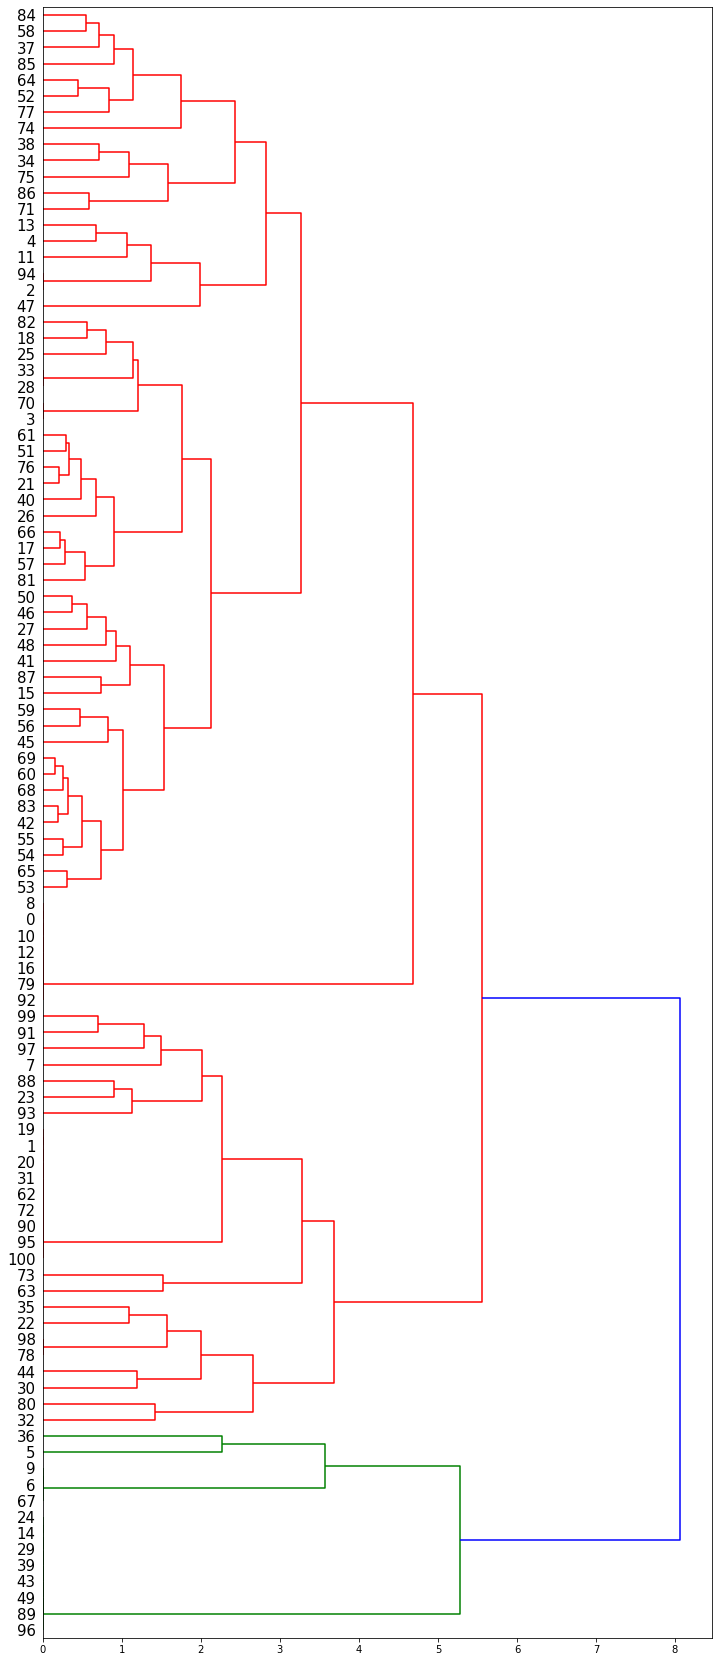

In [62]:
Z = hierarchy.linkage(dist_matrix, 'complete')
fig = pylab.figure(figsize=(12,30))
dendro = hierarchy.dendrogram(Z, labels = list(Summary.index), leaf_rotation=0, leaf_font_size =15, orientation = 'right')

### The results are satisfying in terms of grouping technique since the clusters are rather balanced
### and small as seen in the dendrogram (especially in its lower part). Frequency table also shows this:

In [63]:
#Summary = Summary.set_index('Postcode')
Summary['HR Cluster Labels'].value_counts()

6    43
4    15
1    12
8    10
0     8
2     5
7     3
5     2
3     2
9     1
Name: HR Cluster Labels, dtype: int64

### From the results it can be seen that this algorithm clustered in an even softer manner than the GMM above
### allowing for more, so called, Type 3 clusters. This is great - here's another one for example:

In [64]:
HR_Chart = Summary.groupby(['HR Cluster Labels'])['Restaurant','Park','Hotel','Grocery Store', 'Pub', 'Pharmacy', 'Bank', 'Coffee', 'Pastries', 'Workout'].mean()
HR_Chart

,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout
HR Cluster Labels,,,,,,,,,,
0,0.937500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500
1,0.069444,0.847222,0.000000,0.000000,0.000000,0.041667,0.041667,0.000000,0.000000,0.000000
2,0.100000,0.200000,0.000000,0.200000,0.000000,0.050000,0.000000,0.000000,0.400000,0.050000
3,0.000000,0.266667,0.266667,0.200000,0.000000,0.000000,0.100000,0.000000,0.000000,0.166667
4,0.038889,0.028148,0.000000,0.007407,0.011111,0.077222,0.023148,0.083148,0.096667,0.034259
5,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000
6,0.474126,0.027059,0.025379,0.027440,0.019105,0.014515,0.018951,0.280504,0.069038,0.043883
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
8,0.444167,0.077500,0.000000,0.000000,0.032500,0.012500,0.032500,0.037500,0.330833,0.032500


In [81]:
Summary.loc[Summary['HR Cluster Labels'] == 2]

,HR Cluster Labels,GMM Cluster Labels,MeanShift Cluster Labels,DBSCAN Cluster Labels,Postcode,K Cluster Labels,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout,Latitude,Longitude
78,2,5,2,-1,M6L,6,0.00,0.5,0.0,0.00,0.0,0.00,0.0,0.0,0.50,0.00,43.713756,-79.490074
80,2,5,2,-1,M6N,0,0.00,0.0,0.0,0.50,0.0,0.00,0.0,0.0,0.50,0.00,43.673185,-79.487262
91,2,9,0,-1,M8Z,1,0.25,0.0,0.0,0.25,0.0,0.00,0.0,0.0,0.25,0.25,43.628841,-79.520999
98,2,5,2,-1,M9R,6,0.00,0.5,0.0,0.00,0.0,0.00,0.0,0.0,0.50,0.00,43.688905,-79.554724
99,2,9,0,-1,M9V,1,0.25,0.0,0.0,0.25,0.0,0.25,0.0,0.0,0.25,0.00,43.739416,-79.588437


### An area chart shows a mild picture as expected:

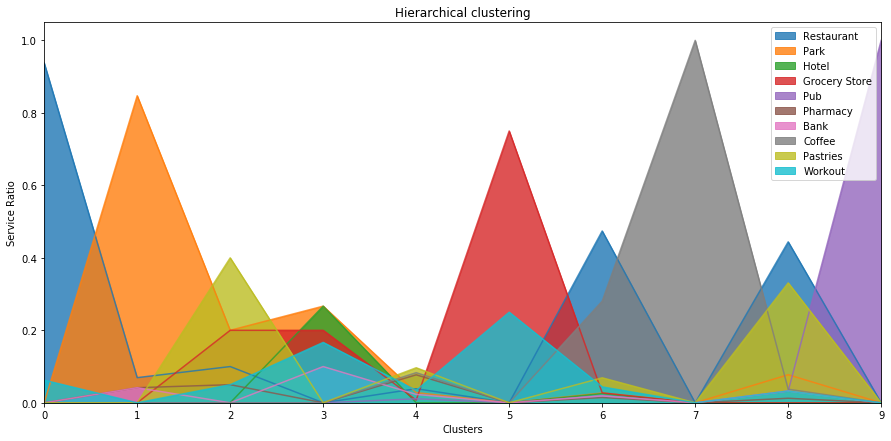

In [66]:
HR_Chart.plot(kind='area', 
             stacked=False,
             figsize=(15, 7),
             alpha=0.8,
             )

plt.title('Hierarchical clustering')
plt.ylabel('Service Ratio')
plt.xlabel('Clusters')

plt.show()

# <span style="color:red">**Summarizing the results generated across all 5 algorithms:**</span>

### Eventually there seem to be 3 types of clusters. The different algorithms uncovered them 
### from different perspectives: K means created some top-down perspective without being too
### precise due to being extra soft. DBSCAN turned out to be too rigid without adding extra
### value on top of K means so from there I tried going to the golden middle with more balanced
### solutions such as MeanShift, GMM and Hierarchical clustering. The last two delivered the 
### optimal results, each showing all three types of cluster:

In [67]:
###

## **1**. Geographically dense areas - this is the initial problem I wished to solve and therefore
## not much I can do with these except to identify and clean them up. For example: M2K, M2J, M5B.

In [68]:
###

## **2**. Clusters with post codes that have a single service in them at most. This is the type of areas that 
## require municipal planning since it is obvious they are those who should take the load of the dense areas. 
## This are not necessarily the outskirts but simply areas that could use more infrastructure development. 
## For example: M6M, M1N, M4E. M6M has only restaurants, M1N has only coffee and M4E has only a pub.

In [69]:
###

## **3**. Clusters with post codes having few services at most, usually between 2-3. These can serve as a 
## business hints for opening up new branches without taking too much risk. For example: in post code M8Z 
## and M9V you have Restaurants+grocery+pastries while in post code M6N you have only grocery and pastries. 
## A restaurant is missing. Why not set it up?

In [70]:
###

### Here's the summarized results:

In [85]:
Summary.set_index('Postcode')
Summary

,HR Cluster Labels,GMM Cluster Labels,MeanShift Cluster Labels,DBSCAN Cluster Labels,Postcode,K Cluster Labels,Restaurant,Park,Hotel,Grocery Store,Pub,Pharmacy,Bank,Coffee,Pastries,Workout,Latitude,Longitude
0,0,3,0,0,M1B,8,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.806686,-79.194353
1,4,0,0,1,M1C,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.784535,-79.160497
2,8,5,0,2,M1E,1,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,43.763573,-79.188711
3,6,9,0,2,M1G,3,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,43.770992,-79.216917
4,8,9,0,2,M1H,1,0.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.200000,0.000000,43.773136,-79.239476
5,5,8,7,-1,M1J,0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.744734,-79.239476
6,7,4,3,3,M1K,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,43.727929,-79.262029
7,8,5,2,-1,M1L,1,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,43.711112,-79.284577
8,0,3,0,0,M1M,8,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.716316,-79.239476
9,7,4,3,3,M1N,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,43.692657,-79.264848
